# Team: Kayla and Hariraj
# Dataset2 Ecommerce Data: A comprehensive Analysis
https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

# Preamble

In [3]:
# imports
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
from wordcloud import WordCloud



# A. Exploration of Dataset

For the exploration, first I am gathering general information regarding  the dataset such as classes and sample number. Then I find out whether there is a good spread of words between each class that would allow for easy feature extraction, and then i plot the word spread on a wordcloud to make it easy to visualize the prevalence of certain words in each class in relation to eachother.

Dataset Structure:
           0                                                  1
0  Household  Paper Plane Design Framed Wall Hanging Motivat...
1  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
2  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
3  Household  SAF Flower Print Framed Painting (Synthetic, 1...
4  Household  Incredible Gifts India Wooden Happy Birthday U...

Number of Samples: 50425
Number of Classes: 4
Number of Attributes: 1

Class Distribution:
0
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64


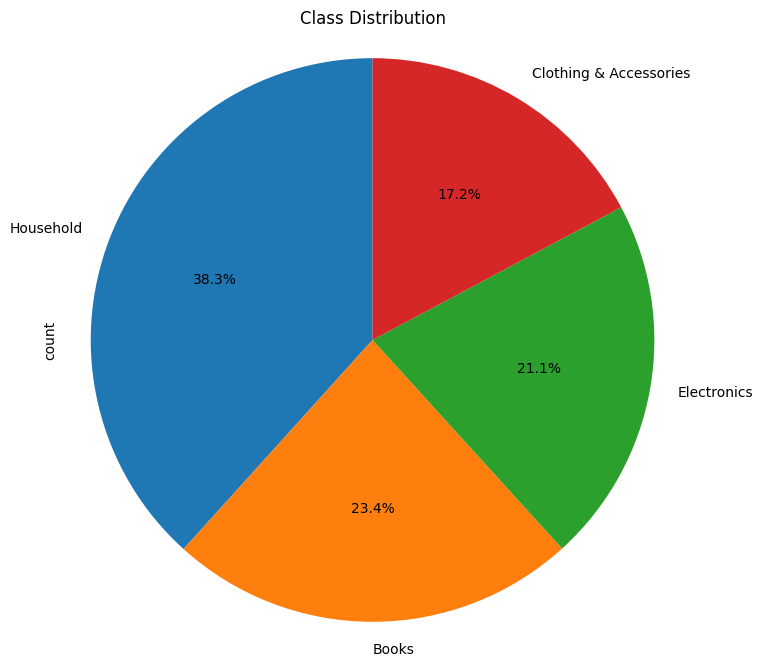

Class-wise Word Count and Unique Words Statistics:
                        word_count  unique_words
class                                           
Books                   135.613198     87.986379
Clothing & Accessories   72.364318     55.835082
Electronics             134.540062     92.978721
Household               108.644954     78.249883

Total Unique Words: 221008


In [37]:
dataset_path = "ecommerceDataset.csv"  
df = pd.read_csv(dataset_path, header=None)  

print("Dataset Structure:")
print(df.head())

num_samples = df.shape[0]
num_classes = df.iloc[:, 0].nunique()  
num_attributes = 1  

print("\nNumber of Samples:", num_samples)
print("Number of Classes:", num_classes)
print("Number of Attributes:", num_attributes)


class_distribution = df.iloc[:, 0].value_counts()  
print("\nClass Distribution:")
print(class_distribution)

plt.figure(figsize=(8, 8))
plt.title("Class Distribution")
df.iloc[:, 0].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.axis('equal')  
plt.show()

text_data_column = df.iloc[:, 1]


df['class'] = df.iloc[:, 0]

def calculate_statistics(text):
    if isinstance(text, str): 
        return len(text.split()), len(set(text.split()))
    else:
        return 0, 0  

word_count, unique_words = zip(*df.iloc[:, 1].apply(calculate_statistics))

df['word_count'] = word_count
df['unique_words'] = unique_words

class_statistics = df.groupby('class')[['word_count', 'unique_words']].mean()

total_unique_words = len(set(" ".join(df.iloc[:, 1].astype(str)).split()))

print("Class-wise Word Count and Unique Words Statistics:")
print(class_statistics)
print("\nTotal Unique Words:", total_unique_words)




Identify missing values, and since there is a missing text entry, drop the row since there is no valid way to replace the information other than duplicating an entry.

In [35]:
missing_values = df.isnull()
total_missing_values = missing_values.sum().sum()
print("Total Number of Missing Values:", total_missing_values)

for index, row in missing_values.iterrows():
    if row.any():
        print(f"Missing value at row {index + 1}:")
        print(df.iloc[index])  
        print("Dropping the entire row.")
        df = df.drop(index)

df = df.reset_index(drop=True)


Total Number of Missing Values: 1
Missing value at row 39331:
0    Clothing & Accessories
1                       NaN
Name: 39330, dtype: object
Dropping the entire row.


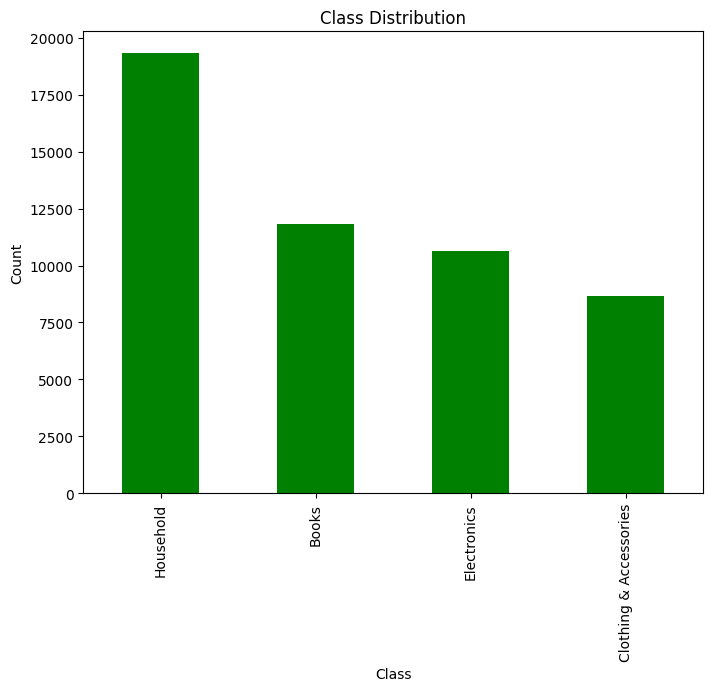

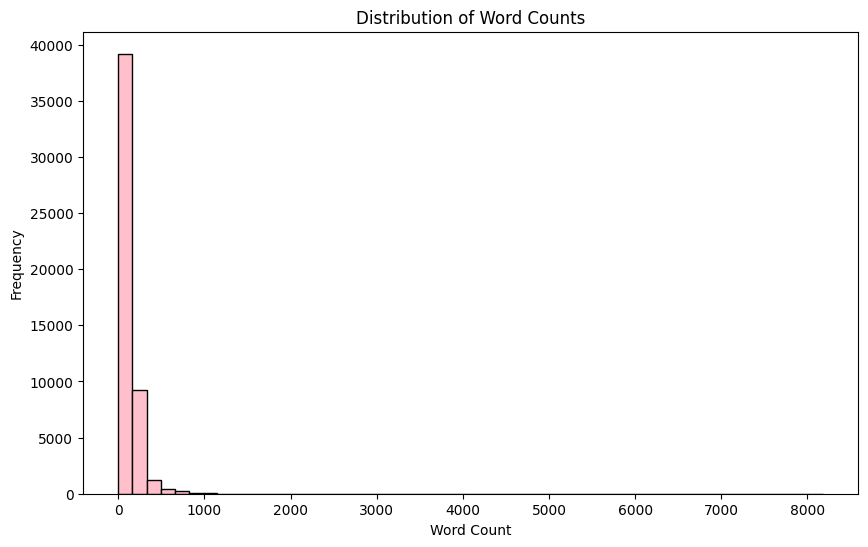

                          count        mean         std  min   25%   50%  \
0                                                                          
Books                   11820.0  135.613198  265.430322  1.0  13.0  78.0   
Clothing & Accessories   8670.0   72.372664   63.721351  1.0  29.0  56.0   
Electronics             10621.0  134.540062  129.034090  1.0  43.0  99.0   
Household               19313.0  108.644954   97.980916  1.0  44.0  83.0   

                          75%     max  
0                                      
Books                   169.0  8181.0  
Clothing & Accessories   92.0   581.0  
Electronics             194.0  1997.0  
Household               146.0  1791.0  


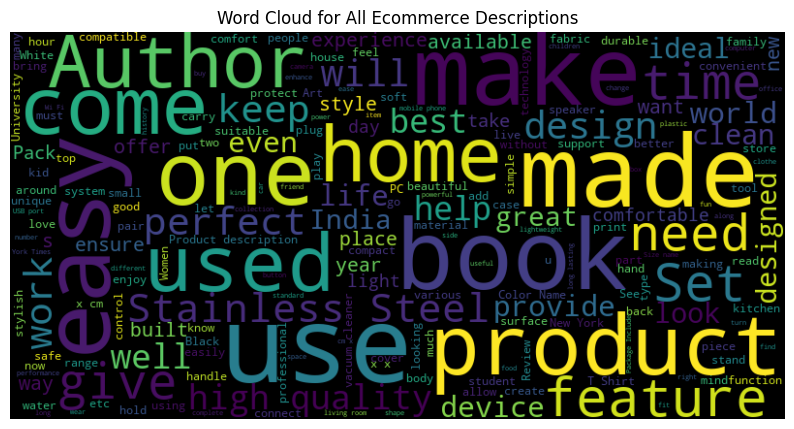

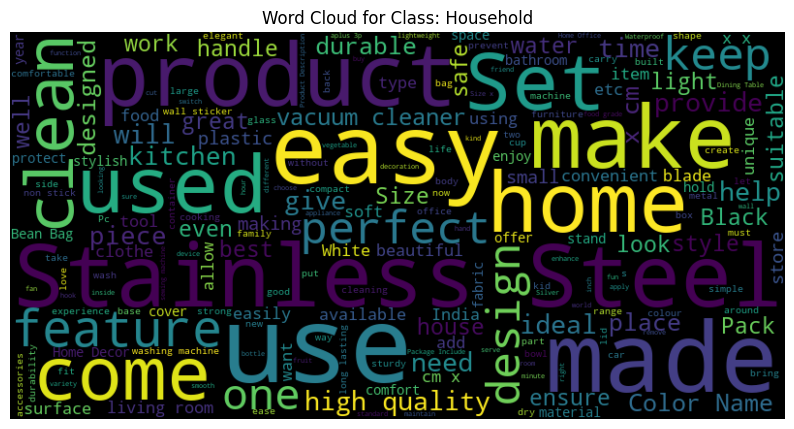

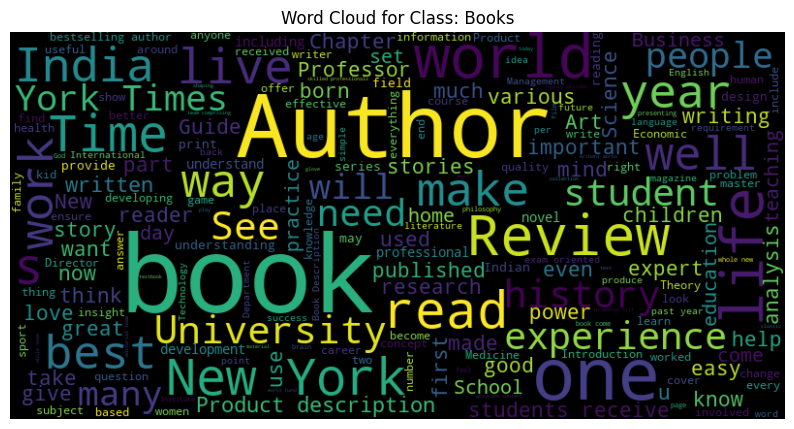

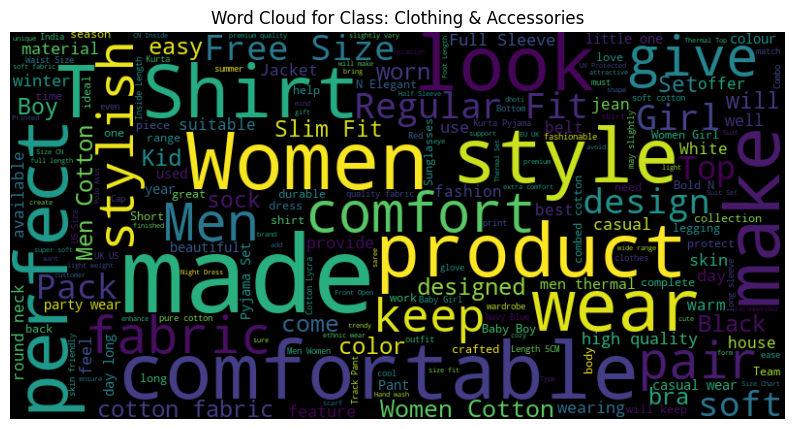

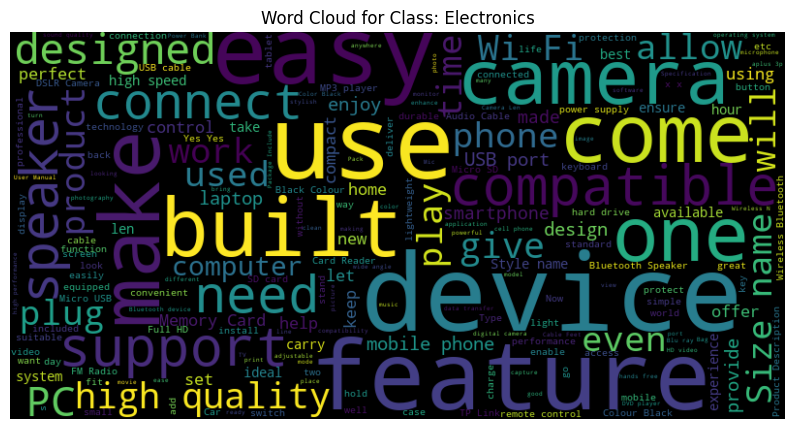

In [36]:
plt.figure(figsize=(8, 6))
df.iloc[:, 0].value_counts().plot(kind='bar', color='green')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

df['word_count'] = df.iloc[:, 1].apply(lambda x: len(x.split()))  

plt.figure(figsize=(10, 6))
df['word_count'].plot(kind='hist', bins=50, color='pink', edgecolor='black')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

summary_stats = df.groupby(df.iloc[:, 0])['word_count'].describe()  
print(summary_stats)






text_combined = ' '.join(df.iloc[:, 1].astype(str))  
wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text_combined)


plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title(f'Word Cloud for All Ecommerce Descriptions')
plt.axis('off')
plt.show()

classes = df.iloc[:, 0].unique()

for class_label in classes:
    text_combined_class = ' '.join(df[df.iloc[:, 0] == class_label].iloc[:, 1])
    wordcloud_class = WordCloud(width=800, height=400, random_state=21, max_font_size=110).generate(text_combined_class)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud_class, interpolation="bilinear")
    plt.title(f'Word Cloud for Class: {class_label}')
    plt.axis('off')
    plt.show()





According to the exploration of the dataset, we have learned that he dataset consists of 50,424 samples with 4 possible classes: "Household," "Books," "Electronics," and "Clothing & Accessories." There is one "attribute" in the dataset, representing the product descriptions from an e-commerce website. The class distribution shows that "Household" has the highest number of samples with 19,312, followed by "Books" with 11,820, "Electronics" with 10,621, and "Clothing & Accessories" with 8,671, which is an imbalanced spread since "Household" has far more samples than any other category. However, for the purpose of classification, this should not be a problem as long as there is no drift between identifying which class each sample belongs to. 

Each text entry, on average, has 79.78 unique words. This reflects a good spread of words within each description, on top of which there are 221008 total unique words spread between all 4 classes. This reflects a specific set of vocabulary being used for each class, as we can observe from the average unique words being different for each class. To further visualize this "vocabulary", we can reference the wordclouds. First, for the general word cloud for every entry, we can see that the most common phrases are split between words that reflect the larger samples amount for Books and Household, with words like Author, Book, and Stainless Steel being some of the largest entries, along with more general descriptive words like One or Two, Product, and High Quality. 

When referencing the the individual wordclouds for each class, we can see just how much of a difference there is between each class. Electronics tend to have descriptors referencing their High Quality, Features, how Easy it is to use, while Clothing and Accessories use descriptors targetting Women and Men, with emphasis on Style and Comfort, while mentioning the make of the material such as Cotton. 

# B. Pre Processing of Dataset

We apply label encoding to fit numerical values to each of the 4 classes, which helps out a little bit with later model training and referencing each class. 

In [38]:

dataset_path = "ecommerceDataset.csv"
df = pd.read_csv(dataset_path, header=None)

label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df.iloc[:, 0])

class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
print(class_mapping)

df = df.drop(columns=[0])

print("Dataset with Label Encoding:")
print(df.head())


nan_rows = df[df.isnull().any(axis=1)]

print("Rows containing NaN values:")
print(nan_rows)

df = df.dropna()


Class Mapping:
{'Books': 0, 'Clothing & Accessories': 1, 'Electronics': 2, 'Household': 3}
Dataset with Label Encoding:
                                                   1  class_encoded
0  Paper Plane Design Framed Wall Hanging Motivat...              3
1  SAF 'Floral' Framed Painting (Wood, 30 inch x ...              3
2  SAF 'UV Textured Modern Art Print Framed' Pain...              3
3  SAF Flower Print Framed Painting (Synthetic, 1...              3
4  Incredible Gifts India Wooden Happy Birthday U...              3
Rows containing NaN values:
         1  class_encoded
39330  NaN              1


[1]

We apply stemming (porter stem algo gets rid of suffixes specifcally) which "normalizes" the text entries and then we iterate through each stemmed token to make sure every word is lowercase, getting rid of punctuation, and reduces words to their base form. For example swimming, swims, and swimmer would all be descriped as swim. Doing this feature reduction allows us to avoid making our feature space unwieldy and large to perform our training on (especially with the devices I have). Considerations we have to make are that there are in fact examples where the word stems for two completely different meanings are the same eg. new and news. However, this is a drawback we must accept in this case otherwise we would be left with a feature space too large to deal with on my old laptop, and we can most likely trace back misclassification to this stemming procedure. We then iterate back through the dataframe and replace entries with the stemmed entries. 

In [39]:
ps = PorterStemmer()

def preprocess_text(text):
    if isinstance(text, (float, np.float64)):
        return ''  
    
    tokens = word_tokenize(text)
    
    tokens = [word.lower() for word in tokens if word.isalpha()]
    
    tokens = [ps.stem(word) for word in tokens]
    
    return ' '.join(tokens)

df[1] = df[1].apply(preprocess_text)

print("DataFrame after Text Preprocessing:")
print(df.head())


DataFrame after Text Preprocessing:
                                                   1  class_encoded
0  paper plane design frame wall hang motiv offic...              3
1  saf frame paint wood inch x inch special effec...              3
2  saf textur modern art print frame paint synthe...              3
3  saf flower print frame paint synthet inch x in...              3
4  incred gift india wooden happi birthday uniqu ...              3


# Part C: Feature Extraction/Feature Learning

In [42]:

vectorizer_bow = CountVectorizer(max_features=1000)
bow_features = vectorizer_bow.fit_transform(df[1])

vectorizer_tfidf = TfidfVectorizer(max_features=1000)
tfidf_features = vectorizer_tfidf.fit_transform(df[1])


X = pd.concat([pd.DataFrame(bow_features.toarray()), pd.DataFrame(tfidf_features.toarray())], axis=1)
X = X.dropna()
y = df['class_encoded']
print("this is X:")
print(X.columns)

this is X:
Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
      dtype='int64', length=2000)


[1] 
Every sample in this dataset is a text sample, so we have to do vectorization in order to represent the data in a way we can train our model on. I decided to use Bag of Words and TD-IDF in order to vectorize my stemmed text entries. Bag of words turns each entry into a "word count" vector, allowing us to place weight upon the frequency of every token. TD-IDF on the other hand, allows us to bring to the forefront less used words, since the vectorization is based on the inverse document frequency. This means that we can now place larger weights upon words that appear less often (which could mean a specific use case in a specific class), while placing less weight on words that are ubiquitous(words like the, is, it, which does not provide us with much context). The combination of the two should allow for a good training set with an emphasis on both word rarity, as well as word count. I set the max_features to 1000 so my computer can handle the training, as within my own testing larger values led to training times of upwards of an hour and most times just my computer crashing.

# Part D: Processing using two different machine learning method

Method 1: Using Random Forest
[2]
For our first, we employ the Random Forest algorithm, a powerful ensemble learning method. Random Forest builds multiple decision trees during training and merges their predictions to enhance accuracy and control overfitting.

 I first initialize and RF classifier with 100 trees, and set the seed to a standard 42 to ensure I can use the same state on every run and ensure reproducability. Then I combine the feature matrix and target vars, and perferm K-fold cross validation, using 5 folds in this case. I focus on accuracy, precision, recall, and F1 score, and then choose accuracy as the best performance metric upon which to base the model. 
 
 I have also checked to make sure the model wasn't giving back a 100% test data accuracy, as that could mean overfitting or that the test data ended up being used in the training data set.


The parameter I am tuning in this case is the n_estimators value, which corresponds with the actual number of trees 


In [56]:
best_n_estimators = None
best_test_accuracy = 0.0  


n_estimators_values = [1, 10, 100]


for n_estimators in n_estimators_values:

    rf_model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)

    
    df_cleaned = pd.concat([X, y], axis=1).dropna()
    X_cleaned = df_cleaned.drop('class_encoded', axis=1)
    y_cleaned = df_cleaned['class_encoded']

    X_cleaned.columns = X_cleaned.columns.astype(str)

   
    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(rf_model, X_cleaned, y_cleaned, cv=kfold, scoring=scoring_metrics, return_train_score=True)


    print(f"Results for n_estimators={n_estimators}:")
    for metric in scoring_metrics:
        train_metric_key = f"train_{metric}"
        test_metric_key = f"test_{metric}"
        print(f"Mean {metric.capitalize()} (Train): {cv_results[train_metric_key].mean():.2f}")
        print(f"Mean {metric.capitalize()} (Test): {cv_results[test_metric_key].mean():.2f}")
        print()

    
    if cv_results['test_accuracy'].mean() > best_test_accuracy:
        best_test_accuracy = cv_results['test_accuracy'].mean()
        best_n_estimators = n_estimators

    print("\n" + "="*50 + "\n")  


best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
best_rf_model.fit(X_cleaned, y_cleaned)

y_pred_rf = best_rf_model.predict(X_cleaned)


accuracy = accuracy_score(y_cleaned, y_pred_rf)
print(f"Best n_estimators={best_n_estimators}")
print("Accuracy on the entire dataset: {:.2f}%".format(100 * accuracy))


Results for n_estimators=1:
Mean Accuracy (Train): 0.96
Mean Accuracy (Test): 0.91

Mean Precision_macro (Train): 0.97
Mean Precision_macro (Test): 0.91

Mean Recall_macro (Train): 0.96
Mean Recall_macro (Test): 0.91

Mean F1_macro (Train): 0.97
Mean F1_macro (Test): 0.91



Results for n_estimators=10:
Mean Accuracy (Train): 1.00
Mean Accuracy (Test): 0.96

Mean Precision_macro (Train): 1.00
Mean Precision_macro (Test): 0.96

Mean Recall_macro (Train): 1.00
Mean Recall_macro (Test): 0.96

Mean F1_macro (Train): 1.00
Mean F1_macro (Test): 0.96



Results for n_estimators=100:
Mean Accuracy (Train): 1.00
Mean Accuracy (Test): 0.97

Mean Precision_macro (Train): 1.00
Mean Precision_macro (Test): 0.97

Mean Recall_macro (Train): 1.00
Mean Recall_macro (Test): 0.97

Mean F1_macro (Train): 1.00
Mean F1_macro (Test): 0.97



Best n_estimators=100
Accuracy on the entire dataset: 99.85%


As expected the largest tree value returns to us the best model, especially since there is such a large gap between the numbers uses for trees. Ideally, a larger amount of trees could give us an even better model, but we are limited by computational costs, but it would be a way to take t he model even further.

A bar chart of the averages of performance metrics for the best n_estimator value (=100) 

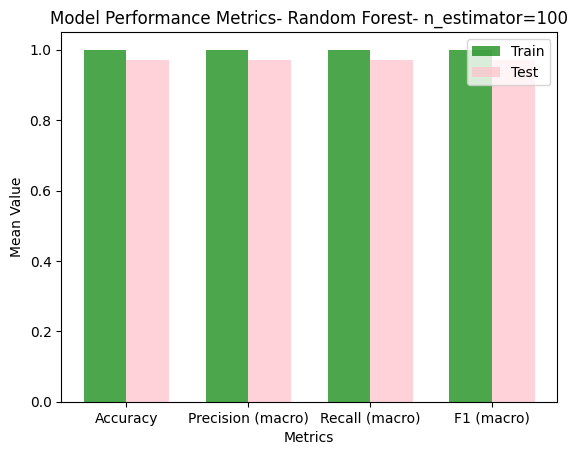

In [58]:


mean_accuracy_train = 1.00
mean_accuracy_test = 0.97
mean_precision_macro_train = 1.00
mean_precision_macro_test = 0.97
mean_recall_macro_train = 1.00
mean_recall_macro_test = 0.97
mean_f1_macro_train = 1.00
mean_f1_macro_test = 0.97

metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)']
train_values = [mean_accuracy_train, mean_precision_macro_train, mean_recall_macro_train, mean_f1_macro_train]
test_values = [mean_accuracy_test, mean_precision_macro_test, mean_recall_macro_test, mean_f1_macro_test]

bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='green', alpha=0.7)
plt.bar(index + bar_width, test_values, bar_width, label='Test', color='pink', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Mean Value')
plt.title('Model Performance Metrics- Random Forest- n_estimator=100')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

plt.show()


Method 2: Extreme Gradient Boosting
[3]
For our second model, we implement extreme gradient boosting, which is just an offset of the gradient boosting algorithm. 

Here I use the softmax to account for my model being trained for multiclass, and then set the class number to 4. I combine the feature matrix and the target vars, and perform K-fold cross validation with 5 folds. I focus on accuracy, precision, recall, and F1 score, and then choose accuracy as the best performance metric upon which to base the model. 

I have also checked to make sure the model wasn't giving back a 100% test data accuracy, as that could mean overfitting or that the test data ended up being used in the training data set.

The parameter I am changing is the learning_rate, which corresponds to the step size at which the algorithm updates the model, hence how fast it converges. 

In [57]:
best_learning_rate = None
best_test_accuracy = 0.0  


learning_rate_values = [0.01, 0.1, 1.0]


for learning_rate in learning_rate_values:
    
    xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, learning_rate=learning_rate)

    
    df_cleaned = pd.concat([X, y], axis=1).dropna()
    X_cleaned = df_cleaned.drop('class_encoded', axis=1)
    y_cleaned = df_cleaned['class_encoded']

    X_cleaned.columns = X_cleaned.columns.astype(str)

    feature_names = [f'feature_{i}' for i in range(X_cleaned.shape[1])]
    X_cleaned.columns = feature_names

    
    scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(xgb_model, X_cleaned, y_cleaned, cv=kfold, scoring=scoring_metrics, return_train_score=True)

    
    print(f"Results for learning_rate={learning_rate}:")
    for metric in scoring_metrics:
        train_metric_key = f"train_{metric}"
        test_metric_key = f"test_{metric}"
        print(f"Mean {metric.capitalize()} (Train): {cv_results[train_metric_key].mean():.2f}")
        print(f"Mean {metric.capitalize()} (Test): {cv_results[test_metric_key].mean():.2f}")
        print()

    
    if cv_results['test_accuracy'].mean() > best_test_accuracy:
        best_test_accuracy = cv_results['test_accuracy'].mean()
        best_learning_rate = learning_rate

    print("\n" + "="*50 + "\n")  


best_xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, random_state=42, learning_rate=best_learning_rate)
best_xgb_model.fit(X_cleaned, y_cleaned)


y_pred_xgb = best_xgb_model.predict(X_cleaned)


accuracy = accuracy_score(y_cleaned, y_pred_xgb)
print(f"Best learning_rate={best_learning_rate}")
print("Accuracy on the entire dataset: {:.2f}%".format(100 * accuracy))


Results for learning_rate=0.01:
Mean Accuracy (Train): 0.87
Mean Accuracy (Test): 0.87

Mean Precision_macro (Train): 0.90
Mean Precision_macro (Test): 0.89

Mean Recall_macro (Train): 0.86
Mean Recall_macro (Test): 0.86

Mean F1_macro (Train): 0.87
Mean F1_macro (Test): 0.87



Results for learning_rate=0.1:
Mean Accuracy (Train): 0.94
Mean Accuracy (Test): 0.93

Mean Precision_macro (Train): 0.95
Mean Precision_macro (Test): 0.94

Mean Recall_macro (Train): 0.94
Mean Recall_macro (Test): 0.93

Mean F1_macro (Train): 0.94
Mean F1_macro (Test): 0.93



Results for learning_rate=1.0:
Mean Accuracy (Train): 1.00
Mean Accuracy (Test): 0.97

Mean Precision_macro (Train): 1.00
Mean Precision_macro (Test): 0.97

Mean Recall_macro (Train): 1.00
Mean Recall_macro (Test): 0.97

Mean F1_macro (Train): 1.00
Mean F1_macro (Test): 0.97



Best learning_rate=1.0
Accuracy on the entire dataset: 99.51%


As observed from the performance metrics, the learning_rate=1.0 performed the best in the kfold cross validation and is then applied to the entire data, and has an accuracy of 99.51%.

The relatively high learning rate being the best parameter reflects that the n_estimate for the xgb model should be greater. However, due to computational limitations that is not possible, but ideally a larger number of trees with a smaller learning rate would give us an even better model.

A bar chart of the averages of performance metrics, between test and train datasets.

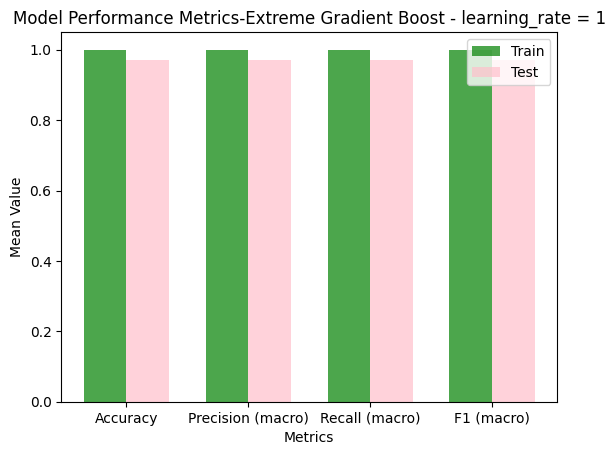

In [60]:


mean_accuracy_train = 1.00
mean_accuracy_test = 0.97
mean_precision_macro_train = 1.00
mean_precision_macro_test = 0.97
mean_recall_macro_train = 1.00
mean_recall_macro_test = 0.97
mean_f1_macro_train = 1.00
mean_f1_macro_test = 0.97

metrics = ['Accuracy', 'Precision (macro)', 'Recall (macro)', 'F1 (macro)']
train_values = [mean_accuracy_train, mean_precision_macro_train, mean_recall_macro_train, mean_f1_macro_train]
test_values = [mean_accuracy_test, mean_precision_macro_test, mean_recall_macro_test, mean_f1_macro_test]

bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, train_values, bar_width, label='Train', color='green', alpha=0.7)
plt.bar(index + bar_width, test_values, bar_width, label='Test', color='pink', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Mean Value')
plt.title('Model Performance Metrics-Extreme Gradient Boost - learning_rate = 1')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

plt.show()


# Part E: Comparitive Analysis of the Two Methods

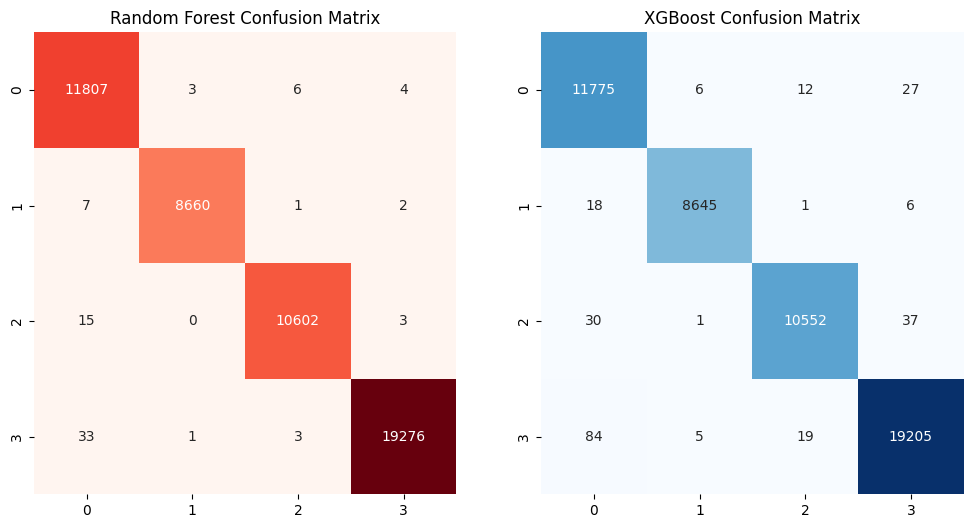

In [59]:

xgb_conf_matrix = confusion_matrix(y_cleaned, y_pred_xgb)

rf_conf_matrix = confusion_matrix(y_cleaned, y_pred_rf)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False)
plt.title('Random Forest Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix')

plt.show()




Based on the confusion matrix and accuracy scores of both RF and xGB models, I would recommend to use the RF model. This model has a 99.85% accuracy rate, compared to xGB's 99.51%. Referencing the confusion matrix, the number of incorrectly classified samples is noticeably lower in the RF model, and though the xGB model also performed very well, the best one based on our test data is the random forest model.

# Part F: Discussion on ethical issues

Given the source of the ecommerce data being from an Indian website, the are a number of concerns regarding the bias of our model, specically to those who are not in India. The model may be tuned to the preferences, behaviors, and patterns of Indian consumers, making it less effective for users from other regions. Though not possible within our current model, ways to mitigate this bias if we were to move forward with our project would be to include ecommerce data from multiple regions, which would give us a more holistic representation and would likely be a better indicator of the needs of the consumer.

Related to this geographical bias would be the risk of discriminatory outcomes when this model is extended to the general population. Demographic differences between user information in India, and then expanded to a wider audience, could cause certain populations to receive unfair recommendations. The only way to combat this would be audit our model regularly and assess whether it discriminates against any race, gender, and paramount to ecommerce data-> socioeconomic standing.

Another major consideration we must make is the privacy of consumer/sellers, and while  this dataset has no explicit names or locations within it, our model along with other datasets from the ecommerce site may lead  to the exposure of sensitive user information, like selling and buying history, tagged with location or identity, which is a very serious issue. With a larger dataset that links the product information to transaction and user history, we have to implement more security features in order to ascertain user privacy.



# Part G: Bibliography

[1]https://mayurji.github.io/blog/2021/09/20/Tf-Idf
    - Used to understand how BoW and TF-IDF implementations work, and what the benefits and preprocessing requirements are to use them
[2]https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    -Used to understand syntax and what the hyper parameters for RF classifier function mean, as well as to select the best one for our model
[3]https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
    -Used to understand syntax what the hyper parameters for xgb classifier function mean, as well as to select the best one for our model
[4]https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
    - Further reference to understand what each hyper parameter meant for RF classifiers, as previous link was hard  to follow at  times.